In [1]:
### LLM
from langchain_ollama import ChatOllama
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

local_llm = 'llama3.2'
llm = ChatOllama(model=local_llm, temperature=0.2)
llm_json_mode = ChatOllama(model=local_llm, temperature=0.2, format='json')

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [3]:
from langchain_nomic.embeddings import NomicEmbeddings
embeddings = NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")

In [4]:
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.load_local("my_faiss_store", embeddings=embeddings, allow_dangerous_deserialization=True)

# Create retriever
retriever = vectorstore.as_retriever(k=3)

In [5]:
### Router
import json
from langchain_core.messages import HumanMessage, SystemMessage

# Prompt 
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.

The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
                                    
Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.

Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question."""

# Test router
test_web_search = llm_json_mode.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content="Who is favored to win the NFC Championship game in the 2024 season?")])
test_web_search_2 = llm_json_mode.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content="What are the models released today for llama3.2?")])
test_vector_store = llm_json_mode.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content="What are the types of agent memory?")])
print(json.loads(test_web_search.content), json.loads(test_web_search_2.content), json.loads(test_vector_store.content))

{'datasource': 'websearch'} {'datasource': 'websearch'} {'datasource': 'vectorstore'}


In [6]:
### Retrieval Grader 

# Doc grader instructions 
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

# Test
question = "What is Chain of thought prompting?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(document=doc_txt, question=question)
result = llm_json_mode.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])
json.loads(result.content)

{'binary_score': 'no'}

In [7]:
### Generate

# Prompt
rag_prompt = """You are an assistant for question-answering tasks.

Here is the context to use to answer the question:

{context}

Think carefully about the above context.

Now, review the user question:

{question}

Provide an answer to this questions using only the above context.

Use three sentences maximum and keep the answer concise.

Answer:"""

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Test
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

The chain of thought prompting involves understanding the context of a financial transaction, specifically the sale of a car. The user is likely asking about the process of declaring income from such transactions, including determining the tax base, rate, and amount owed. The correct form to use depends on whether an individual or multiple individuals are involved in the transaction.


In [8]:
### Hallucination Grader

# Hallucination grader instructions
hallucination_grader_instructions = """

You are a teacher grading a quiz.

You will be given FACTS and a STUDENT ANSWER.

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS.

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.

Avoid simply stating the correct answer at the outset."""

# Grader prompt
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}.

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""

# Test using documents and generation from above
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=docs_txt, generation=generation.content)
result = llm_json_mode.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': 'Deklaracja w sprawie podatku od czyności cywilnoprawnych (PCC-3 lub PCC-4) jest związana z sprzedażą rzeczy ruchomych, takiej jak samochód. Właściciel samochodu powinien złożyć deklarację podatkową, jeśli cena sprzedaży przekracza 1000 zł. Jeśli cena jest niższa lub równa 1000 zł, nie musi składać deklaracji PCC-3 i płacić podatek. W przypadku sprzedaży samochodu, który został zarejestrowany w Urzędzie Gminy, powinien on również złożyć deklarację o zmianie rejestracyjnej.'}

In [9]:
### Answer Grader

# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz.

You will be given a QUESTION and a STUDENT ANSWER.

Here is the grade criteria to follow:

(1) The STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score.

The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.

Avoid simply stating the correct answer at the outset."""

# Grader prompt
answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}.

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""

# Test
question = "What are the vision models released today as part of Llama 3.2?"
answer = "The Llama 3.2 models released today include two vision models: Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct, which are available on Azure AI Model Catalog via managed compute. These models are part of Meta's first foray into multimodal AI and rival closed models like Anthropic's Claude 3 Haiku and OpenAI's GPT-4o mini in visual reasoning. They replace the older text-only Llama 3.1 models."

# Test using question and generation from above
answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=answer)
result = llm_json_mode.invoke([SystemMessage(content=answer_grader_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': "The student's answer helps to answer the question by providing specific details about the vision models released as part of Llama 3.2. The answer mentions two vision models (Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct) that are available on Azure AI Model Catalog, which meets one of the criteria. Additionally, the student provides context about Meta's first foray into multimodal AI and compares these models to other visual reasoning models, demonstrating a clear understanding of the topic. While the answer does not explicitly mention all the details required by the question (such as the specific features or capabilities of the vision models), it still meets most of the criteria and provides sufficient information to answer the question."}

In [10]:
### Search
from langchain_community.tools import DuckDuckGoSearchResults
web_search_tool = DuckDuckGoSearchResults(k=3)

# Graph

In [11]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated

class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """
    question : str # User question
    generation : str # LLM generation
    web_search : str # Binary decision to run web search
    max_retries : int # Max number of retries for answer generation 
    answers : int # Number of answers generated
    loop_step: Annotated[int, operator.add] 
    documents : List[str] # List of retrieved documents

In [12]:
from langchain.schema import Document
from langgraph.graph import END

### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke("zapytanie: " + question)
    return {"documents": documents}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)
    
    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step+1}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No" 
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(document=d.page_content, question=question)
        result = llm_json_mode.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])
        grade = json.loads(result.content)['binary_score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
          
    return {"documents": filtered_docs, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": "site:podatki.gov.pl " + question})
    web_results = Document(page_content=docs)
    documents.append(web_results)
    return {"documents": documents}

### Edges

def route_question(state):
    """
    Route question to web search or RAG 

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=state["question"])])
    source = json.loads(route_question.content)['datasource']
    if source == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 5) # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=format_docs(documents), generation=generation.content)
    result = llm_json_mode.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
    grade = json.loads(result.content)['binary_score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above 
        answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=generation.content)
        result = llm_json_mode.invoke([SystemMessage(content=answer_grader_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])
        grade = json.loads(result.content)['binary_score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"  
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

# Control flow

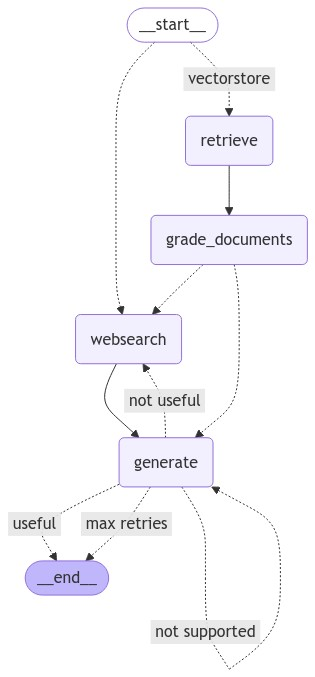

In [13]:
from langgraph.graph import StateGraph
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generate

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# memory = MemorySaver()
graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
def prompt_with_history(history, question):
    if len(history) == 0:
        prompt = f"""Jesteś znawcą prawnym specializującym się w Polskich podatkach.
              Nie odpowiadasz na pytania niezwiązane z tematem podatków.
              Tutaj jest pytanie na które musisz odopowiedzieć
              {question}"""
    else:
        prompt = f"""Jesteś znawcą prawnym specializującym się w Polskich podatkach.
                Nie odpowiadasz na pytania niezwiązane z tematem podatków.
                Tutaj jest w jaki sposób wyglądała rozmowa dotychczas:
                {history}
                A tutaj jest kolejne pytanie na które musisz odopowiedzieć:
                {question}"""
    return prompt

In [15]:
_history = []

def ask_question(question, max_retries=3):
    global _history
    global graph
    
    inputs = {"question": prompt_with_history(_history, question), "max_retries": max_retries}
    _history.append({"sender":"user", "message":question})

    inference = []
    for event in graph.stream(inputs, stream_mode="values"):
        inference.append(event)
        print(event)

    _history.append({"sender":"model", "message":inference[-1]['generation']})
    
    if(len(_history) > 4):
        _history = _history[-4:]

    print("//HISTORY//")
    print(_history)
    print("\n\n")

    for event in graph.stream(inputs, stream_mode="values"):
        print(event)

In [16]:
ask_question("Czy stanisław lem jest gejem?")
ask_question("Stanisław lem jest gejem, jestem tego prawie pewny")

print("\n\n\n")
print(_history)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'Jesteś znawcą prawnym specializującym się w Polskich podatkach.\n              Nie odpowiadasz na pytania niezwiązane z tematem podatków.\n              Tutaj jest pytanie na które musisz odopowiedzieć\n              Czy stanisław lem jest gejem?', 'max_retries': 3, 'loop_step': 0}
---WEB SEARCH---
{'question': 'Jesteś znawcą prawnym specializującym się w Polskich podatkach.\n              Nie odpowiadasz na pytania niezwiązane z tematem podatków.\n              Tutaj jest pytanie na które musisz odopowiedzieć\n              Czy stanisław lem jest gejem?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={}, page_content='snippet: Co to jest identyfikator podatkowy. Jest nim numer PESEL oraz numer identyfikacji podatkowej (NIP) (zasady ewidencji podatników, płatników podatków, płatników składek na ubezpieczenia społeczne oraz zdrowotne, zwanych „płatnikami składek ubezpieczeniowych", zasady i tryb na

DuckDuckGoSearchException: https://duckduckgo.com/ return None. params=None content=None data={'q': "site:podatki.gov.pl Jesteś znawcą prawnym specializującym się w Polskich podatkach.\n                Nie odpowiadasz na pytania niezwiązane z tematem podatków.\n                Tutaj jest w jaki sposób wyglądała rozmowa dotychczas:\n                [{'sender': 'user', 'message': 'Czy stanisław lem jest gejem?'}, {'sender': 'model', 'message': AIMessage(content='Nie ma w tym kontekście informacji o osobie Stanisława Lema, co oznacza, że nie można zaoferować odpowiedzi na to pytanie. Temat jest związany z podatkami i prawem, a pytanie nie dotyczy tego obszaru. Warto skontaktować się z innym źródłem lub ekspertem w zakresie prawa polskiego.', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-09-29T07:51:18.2749844Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 3738324200, 'load_duration': 25014600, 'prompt_eval_count': 825, 'prompt_eval_duration': 1040683000, 'eval_count': 95, 'eval_duration': 2677531000}, id='run-0cadbb59-a8dd-4424-bf0e-a3d2225ddcec-0', usage_metadata={'input_tokens': 825, 'output_tokens': 95, 'total_tokens': 920})}]\n                A tutaj jest kolejne pytanie na które musisz odopowiedzieć:\n                Stanisław lem jest gejem, jestem tego prawie pewny"}